## Wikipedia Views

In [ ]:
!pip install great_tables
# !python3 -m pip install adviz

In [1]:
import sovai as sov

sov.basic_auth("your_email@example.com", "your_password")

True

#### Processed Dataset

In [1]:
import sovai as sov

sov.token_auth(token="your_token_here")

In [2]:
df_wiki = sov.data("wikipedia/views", start_date="2017-03-30", tickers=['IBM', 'BRK.A', 'TM', 'F', 'BMWYY', 'WMT', 'DIS', 'MSFT', 'WWE', 'GOOGL'])

In [3]:
df_wiki

In [74]:
df_wiki = sov.data("wikipedia/views", start_date="2023-03-30")


In [76]:
df_wiki_plot = df_wiki.reset_index()
# df_wiki_plot = df_wiki_plot[df_wiki_plot["date"]>"2023-03-30"]

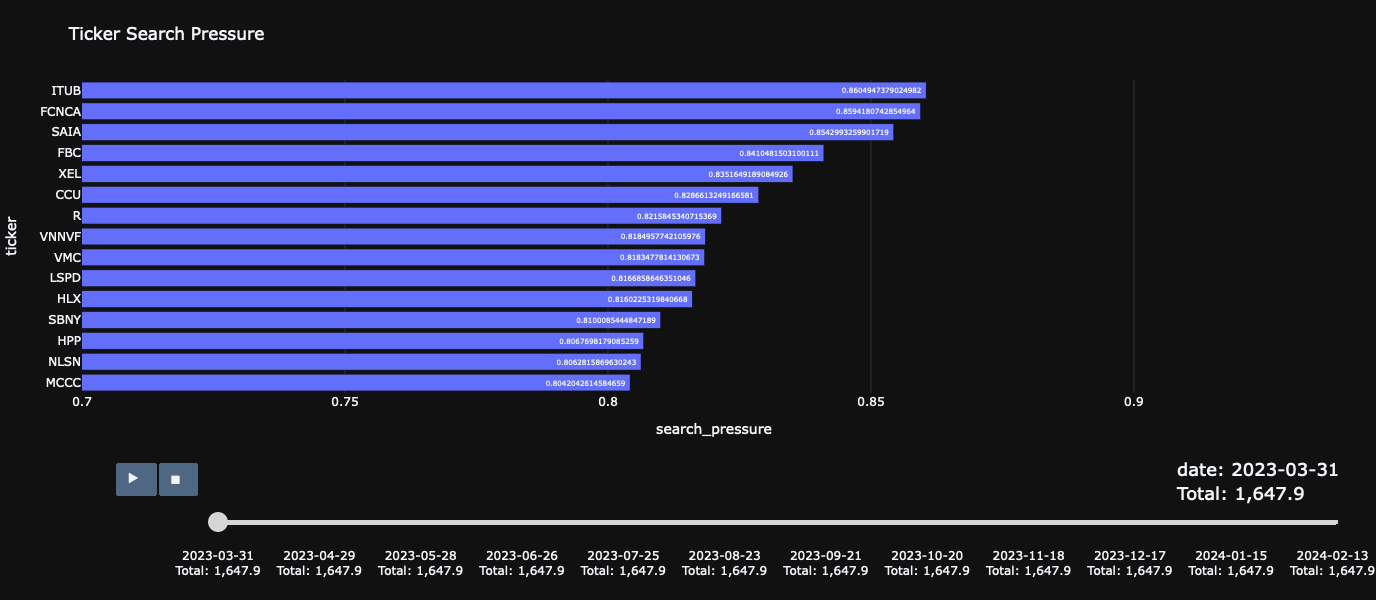

In [146]:
import pandas as pd
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
# import adviz

# %% ../nbs/03_racing_chart.ipynb 4
def racing_chart(
    df,
    n=10,
    title="Racing Chart",
    frame_duration=500,
    theme='none',
    width=None,
    height=600,
    font_size=12):
    """
    Create a racing bar chart showing the top `n` values for each period.

    Parameters
    ----------
    df : pandas.DataFrame
      A DataFrame containing three columns for entity, metric, and period. The
      names can be anything bu they have to be in this specific order.
    n : int
      The number of top items to display for each period.
    title : str
      The title of the chart.
    frame_duration : int
      The duration of each frame during animation, before transitioning to the
      following frame, in milliseconds.
    theme : str
      The theme of the chart. Any of the following values can be used:
    width : int
      The width of the chart in pixels.
    height : int
      The height of the chart in pixels.
    font_size : int
      The size of the fonts in the chart.

    Returns
    -------
    racing_barchart : plotly.graph_objects.Figure
    """
    period_totals = df.groupby(df.columns[2]).sum(df.columns[1]).reset_index()
    # df[f'{df.columns[1]} %'] = df.groupby(df.columns[2])[df.columns[1]].transform(lambda x: x / x.sum())
    top_n_df = (df
        .sort_values([df.columns[2], df.columns[1]],
                     ascending=[True, False])
        .groupby(df.columns[2])
        .head(n))
    fig = px.bar(
        top_n_df,
        x=df.columns[1],
        y=df.columns[0],
        text=df.columns[1],
        animation_frame=df.columns[2],
        hover_name=df.columns[0],
        height=height,
        width=width,
        title=title,
        template=theme,
        range_x=[0,top_n_df[df.columns[1]].max() * 1.05],
    )
    fig.layout.yaxis.autorange = 'reversed'
    fig.layout.font.size = font_size
    fig.layout.sliders[0].currentvalue.xanchor = 'right'
    fig.layout.sliders[0].currentvalue.prefix = fig.layout.sliders[0].currentvalue.prefix.replace('=', ': ')
    fig.layout.sliders[0].currentvalue.font.size = font_size * 1.5
    fig.layout.sliders[0].bgcolor = '#D5D5D5'
    fig.layout.sliders[0].borderwidth = 0
    fig.layout.updatemenus[0]['buttons'][0]['args'][1]['frame']['duration'] = frame_duration
    for step, total in zip(fig.layout.sliders[0].steps, period_totals.iloc[:, 1]):
        step['label'] = f"{step['label']}<br>Total: {total:,}"
    return fig
# Ensure 'date' is in datetime format
df_wiki_plot['date'] = pd.to_datetime(df_wiki_plot['date'])

# Convert 'date' to string format
df_wiki_plot['date'] = df_wiki_plot['date'].astype(str)

# Create the racing chart
fig = racing_chart(
    df_wiki_plot[['ticker', 'search_pressure', 'date']],
    title='Ticker Search Pressure',
    theme='plotly_dark',
    n=15,
    frame_duration=100,
    # height=600,
    width=1400
)

# Adjust layout properties
fig.layout.margin.l = 30
fig.layout.margin.r = 30
fig.layout.margin.t = 80
fig.layout.font.size = 12
fig.layout.xaxis.tickfont.size = 12
fig.layout.yaxis.tickfont.size = 12

# Set the x-axis range to start at 0.5
fig.layout.xaxis.range = [0.7, fig.layout.xaxis.range[1]]

fig

In [173]:
import pandas as pd
import polars as pl
from great_tables import GT, nanoplot_options

# Assuming df_wiki_plot is your pandas DataFrame loaded with data similar to the examples provided

# Filter the DataFrame for the top 10 tickers
top_tickers = ['KOPN', 'FBC', 'GLT', 'APPF', 'ELIO', 'KPELY', 'SMCI', 'SFIX', 'RITM', 'NYCB']
filtered_df = df_wiki_plot[df_wiki_plot['ticker'].isin(top_tickers)]

# Sort the DataFrame by ticker and date to ensure correct ordering
filtered_df = filtered_df.sort_values(by=['ticker', 'date'])

# Group by ticker, and then apply the transformation to get the last 60 'search_pressure' values
result = filtered_df.groupby('ticker').apply(
    lambda x: ' '.join(x.tail(60)['search_pressure'].astype(str))
).reset_index(name='numbers')

# Additional columns formatting
additional_cols = filtered_df.groupby('ticker').apply(
    lambda x: x.tail(60)[['views', 'relative_views','search_pressure','long_short_alpha','long_short_beta']].mean()
).reset_index()

# Merge results and additional_cols
final_result = result.merge(additional_cols, on='ticker', how='left')

# Convert the pandas DataFrame to Polars DataFrame
df_polars = pl.from_pandas(final_result)

# Format the table using great_tables
formatted_table = (
    GT(df_polars)
    .tab_header(title="Ticker Analysis Over Last 60 Days")
    .tab_options(
    # table_background_color="darkgrey",
    # heading_background_color="lightgrey"
    )
    .fmt_number(columns=["views", "relative_views", "search_pressure",'long_short_alpha','long_short_beta'], decimals=3)
    .cols_align(columns=["views", "relative_views", 'search_pressure','long_short_alpha','long_short_beta'], align="center")
    .data_color(
        columns=['search_pressure'],
        palette=["#333333", "#2171b5"],  # Darker to lighter blue suitable for dark backgrounds
        domain=[0, 1],
        na_color="#444444"  # Slightly lighter than the background for NA values
    )
    .data_color(
        columns=["ticker", "views", "relative_views", "search_pressure"],
        palette=["#333333", "#2171b5"],  # Darker to lighter blue suitable for dark backgrounds
        domain=[0, 1],
        na_color="#444444"  # Slightly lighter than the background for NA values
    )
    # .data_color(
    #     columns=["numbers"],
    #     palette=["blue", "blue"],  # Darker to lighter blue suitable for dark backgrounds
    #     domain=[0, 1],
    #     na_color="blue"  # Slightly lighter than the background for NA values
    # )
    .fmt_nanoplot(
        columns="numbers",
        # plot_type="line",
        # plot_height="30px",
        # plot_length="120px",
        
        # autoscale=True,
        options=nanoplot_options(
            data_point_radius=2,
            data_point_fill_color="#2171b5",
            data_line_stroke_color="#2171b5",
            # data_line_stroke_width=1,
            # show_data_area=False,
            # show_y_axis_guide=False,
            # show_vertical_guides=False
        )
    )
)

formatted_table


GT(_tbl_data=shape: (10, 7)
┌────────┬───────────────┬─────────────┬──────────────┬──────────────┬──────────────┬──────────────┐
│ ticker ┆ numbers       ┆ views       ┆ relative_vie ┆ search_press ┆ long_short_a ┆ long_short_b │
│ ---    ┆ ---           ┆ ---         ┆ ws           ┆ ure          ┆ lpha         ┆ eta          │
│ str    ┆ str           ┆ f64         ┆ ---          ┆ ---          ┆ ---          ┆ ---          │
│        ┆               ┆             ┆ f64          ┆ f64          ┆ f64          ┆ f64          │
╞════════╪═══════════════╪═════════════╪══════════════╪══════════════╪══════════════╪══════════════╡
│ APPF   ┆ 0.57163891213 ┆ 116.7       ┆ 0.563648     ┆ 0.607371     ┆ 0.538994     ┆ 0.574982     │
│        ┆ 11874 0.55789 ┆             ┆              ┆              ┆              ┆              │
│        ┆ 512419…       ┆             ┆              ┆              ┆              ┆              │
│ ELIO   ┆ 0.25949472771 ┆ 129.233333  ┆ 0.571315     ┆ 0.430457     ┆ 0.314761     ┆ 0.465831     │
│        ┆ 939225        ┆             ┆              ┆              ┆              ┆              │
│        ┆ 0.2717350919… ┆             ┆              ┆              ┆              ┆              │
│ FBC    ┆ 0.24791936765 ┆ 267.35      ┆ 0.711563     ┆ 0.535399     ┆ 0.413186     ┆ 0.579969     │
│        ┆ 604308        ┆             ┆              ┆              ┆              ┆              │
│        ┆ 0.2620345345… ┆             ┆              ┆              ┆              ┆              │
│ GLT    ┆ 0.34535743439 ┆ 45.616667   ┆ 0.353241     ┆ 0.607955     ┆ 0.527786     ┆ 0.675676     │
│        ┆ 20437 0.35696 ┆             ┆              ┆              ┆              ┆              │
│        ┆ 979650…       ┆             ┆              ┆              ┆              ┆              │
│ KOPN   ┆ 0.49724646858 ┆ 27.366667   ┆ 0.264532     ┆ 0.64032      ┆ 0.540383     ┆ 0.675842     │
│        ┆ 64328 0.49046 ┆             ┆              ┆              ┆              ┆              │
│        ┆ 437547…       ┆             ┆              ┆              ┆              ┆              │
│ KPELY  ┆ 0.49305948310 ┆ 27.083333   ┆ 0.103032     ┆ 0.550439     ┆ 0.527042     ┆ 0.546602     │
│        ┆ 703285        ┆             ┆              ┆              ┆              ┆              │
│        ┆ 0.4933693886… ┆             ┆              ┆              ┆              ┆              │
│ NYCB   ┆ 0.73647132355 ┆ 598.316667  ┆ 0.760188     ┆ 0.797621     ┆ 0.654136     ┆ 0.757505     │
│        ┆ 48117 0.74143 ┆             ┆              ┆              ┆              ┆              │
│        ┆ 093329…       ┆             ┆              ┆              ┆              ┆              │
│ RITM   ┆ 0.44688868514 ┆ 54.416667   ┆ 0.327479     ┆ 0.735682     ┆ 0.522635     ┆ 0.632915     │
│        ┆ 718727        ┆             ┆              ┆              ┆              ┆              │
│        ┆ 0.4474000399… ┆             ┆              ┆              ┆              ┆              │
│ SFIX   ┆ 0.09922228578 ┆ 220.016667  ┆ 0.690016     ┆ 0.42357      ┆ 0.299611     ┆ 0.45127      │
│        ┆ 289333        ┆             ┆              ┆              ┆              ┆              │
│        ┆ 0.1057650231… ┆             ┆              ┆              ┆              ┆              │
│ SMCI   ┆ 0.47521483863 ┆ 1183.133333 ┆ 0.871966     ┆ 0.615519     ┆ 0.472751     ┆ 0.621647     │
│        ┆ 16556 0.47756 ┆             ┆              ┆              ┆              ┆              │
│        ┆ 532486…       ┆             ┆              ┆              ┆              ┆              │
└────────┴───────────────┴─────────────┴──────────────┴──────────────┴──────────────┴──────────────┘, _body=<great_tables._gt_data.Body object at 0x2da7e3610>, _boxhead=Boxhead([ColInfo(var='ticker', type=<ColInfoTypeEnum.default: 1>, column_label='ticker', column_align='left', column_width=None), ColInfo(var='numbers', type=<ColInfoT